# Supplement Section 1: Models and parameter fitting

## Setup

In [1]:
using CSV,DataFrames,Distributions,StatsBase,PythonPlot,Random,Tables,DifferentialEquations,Setfield
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools
cd(dirname(@__FILE__))
# seed 
Random.seed!(123);

## Models: OU vs. DN

In [8]:
θ = GrowthTraceTools.θOU
init

init (generic function with 7 methods)

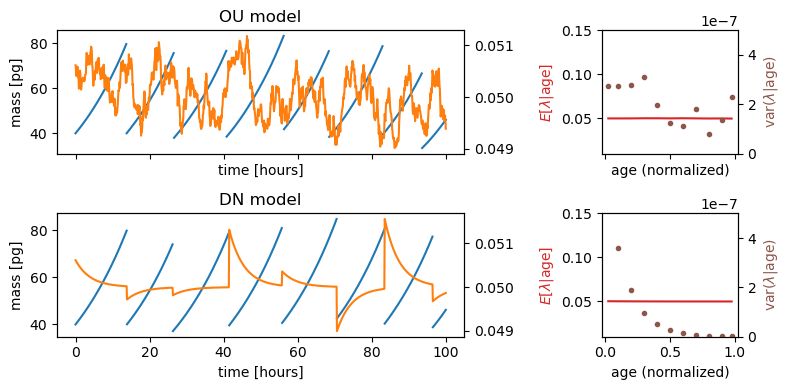

In [15]:

#  setup figure 
fig, axs = subplots(2, 2,gridspec_kw=Dict("width_ratios"=> [3, 1], "height_ratios"=> [1, 1]), figsize=(8, 4),sharex="col")

# ##############################################################################
# OU MODEL 
# ##############################################################################


# build model and run 


# build model and run 
θ = GrowthTraceTools.θOU
θ = @set θ.D = GrowthTraceTools.σGR.^2 /2
init_val = [θ.Δ, θ.λ0 + rand(Normal(0, sqrt(θ.D * θ.τ))), 2 * θ.Δ]
d_OU = GrowthTraceTools.simulate_ou(θ, init_val  ,collect(0:0.1:100) )


#d = sims[sims.lineage_original .==22,:]
d = d_OU[d_OU.position .< 20,:]
da = combine(groupby(d,:age_rounded),:λ => var => :var_gr,:λ => mean => :mean_gr,:age_normed => mean => :age)


ax = axs[0,0]
ax.set_title("OU model")
ax.set_ylabel("mass [pg]")
ax.set_xlabel("time [hours]")
#d1 = d[d.replicate .==1,:]
d1 = d
[ax.plot(d1[d1.position .==p,:].time,d1[d1.position .==p,:].M,"C0") for p in unique(d1.position)]
ax2 = ax.twinx()
ax2.plot(d1.time,d1.λ,"C1")

# Create the second subplot
ax = axs[0,1]
ax.plot(da.age,da.mean_gr,"C3-")
ax.set_ylim([0.01,2*0.075])
ax.set_xlabel("age (normalized)")
ax.set_ylabel(L"$E[\lambda|{\rm age}]$",color="C3")

ax2 = ax.twinx()
ax2.plot(da.age,da.var_gr,"C5.")
ax2.set_ylabel(L"${\rm var}(\lambda|{\rm age})$",color="C5")

ax2.set_ylim([0,5e-7])

# ##############################################################################
#  MODEL 
# ##############################################################################

# -----------------------------------------------------------

θ = GrowthTraceTools.θOU
θ = @set θ.σDN = 0.0
θ = @set θ.D = 0.0
θ = @set θ.σDN = GrowthTraceTools.σGR .* 13. /θ.τ
d_DN = GrowthTraceTools.simulate_ou(θ, init_val  ,collect(0:0.1:100) )

d = d_DN[d_DN.position .< 20,:]
da = combine(groupby(d,:age_rounded),:λ => var => :var_gr,:λ => mean => :mean_gr,:age_normed => mean => :age)

ax = axs[1,0]
ax.set_ylabel("mass [pg]")
ax.set_xlabel("time [hours]")
ax.set_title("DN model")
#d1 = d[d.replicate .==1,:]
d1 = d
[ax.plot(d1[d1.position .==p,:].time,d1[d1.position .==p,:].M,"C0") for p in unique(d1.position)]
ax2 = ax.twinx()
ax2.plot(d1.time,d1.λ,"C1")

# Create the second subplot
ax = axs[1,1]
ax.plot(da.age,da.mean_gr,"C3")
ax.set_ylim([0.01,2*0.075])
ax.set_xlabel("age (normalized)")
ax.set_ylabel(L"$E[\lambda|{\rm age}]$",color="C3")

ax2 = ax.twinx()
ax2.plot(da.age,da.var_gr,"C5.")
ax2.set_ylabel(L"${\rm var}(\lambda|{\rm age})$",color="C5")

ax2.set_ylim([0,5e-7])


tight_layout()
#savefig("./../figures/supp_models1.pdf")
fig

### Test formulas for summed variance

In [16]:
θ = GrowthTraceTools.θOU
θ = @set θ.τ = 5.0
θ_OU = @set θ.D =0.00019/θ.τ

prob,callback,names = GrowthTraceTools.build_model_OU(θ_OU,GrowthTraceTools.initOU,collect(0:0.1:500))
sol = solve(prob,callback = callback);
d_OU = GrowthTraceTools.solver_output_to_dataframe(sol,names);

θ = GrowthTraceTools.θOU
θ = @set θ.D = 0.0
θ_DN = @set θ.σDN = sqrt(0.00019) .* 10 /θ.τ
prob,callback,names = GrowthTraceTools.build_model_OU(θ_DN,GrowthTraceTools.initOU,collect(0:0.1:1000))
sol = solve(prob,callback = callback);
d_DN = GrowthTraceTools.solver_output_to_dataframe(sol,names);

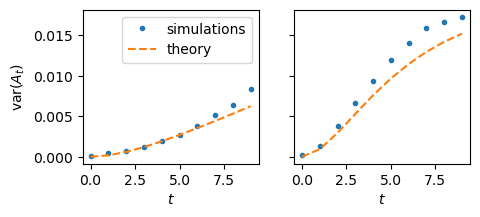

In [17]:
d_OU[:,:y] = vcat([d.lnM_sum .- d.lnM_sum[1]  for d in groupby(d_OU,[:position])]...);
d_OU[:,:ager] =  [round(x) for x in d_OU.age];
d_OU_v = combine(groupby(d_OU,:ager),:y => var => :yvar);

d_DN[:,:y] = vcat([d.lnM_sum .- d.lnM_sum[1]  for d in groupby(d_DN,[:position])]...);
d_DN[:,:ager] =  [round(x) for x in d_DN.age];
d_DN_v = combine(groupby(d_DN,:ager),:y => var => :yvar);


fig, axs= subplots(figsize=(5,2),ncols=2,sharey=true)
max_age = 10


a,v = d_OU_v[d_OU_v.ager .< max_age,:].ager,d_OU_v[d_OU_v.ager .< max_age,:].yvar
axs[0].plot(a,v,".",label="simulations")
axs[0].plot(a,GrowthTraceTools.Avar_theory_OU(a,θ_OU.D,1/θ_OU.τ),"--",label="theory")
axs[0].set_ylabel(L"${\rm var}(A_t)$")
axs[0].set_xlabel(L"$t$")
axs[0].legend()

a,v = d_DN_v[d_DN_v.ager .< max_age,:].ager,d_DN_v[d_DN_v.ager .< max_age,:].yvar
axs[1].plot(a,v,".")
axs[1].plot(a,GrowthTraceTools.Avar_theory_DN(a,θ_DN.σDN .^2,1/θ_DN.τ),"--")
axs[1].set_xlabel(L"$t$")

savefig("./../figures/supp-At_sims-vs-theory.pdf",bbox_inches="tight")
fig

## Fitting procedure and parameters

### Get data

In [18]:
# raw data
data_raw = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);

data_gp = CSV.read("./../output/gp/data/preds.csv",DataFrame)
lineages = unique(data_gp.lineage);
lengths = vcat([
    length(
        unique(data_gp[data_gp.lineage .== lineages[i],:position])
        ) .*
    ones(
        length(
            data_gp[data_gp.lineage .== lineages[i],:time]
            )
        ) 
    for i in eachindex(lineages)]...)
data_gp[:,:length] = lengths
data_gp = data_gp[data_gp.length .>=9,:]
lineages = unique(data_gp.lineage);

data_gp[:,:age] = vcat([d.time .- d.time[1] for d in groupby(data_gp,[:lineage,:position])]...);
data_gp[:,:y] = vcat([d.matern32_flucs .- d.matern32_flucs[1] 
for d in groupby(data_gp,[:lineage,:position])]...);
data_gp[:,:yx] = vcat([d.matern32_flucs_x .- d.matern32_flucs_x[1] 
for d in groupby(data_gp,[:lineage,:position])]...);
data_gp[:,:ager]  = round.(data_gp[:,:age]);


### Plots of fitted parameters

In [21]:
d_fits = CSV.read("./../output/fitted_params.csv",DataFrame)
d_fits[:,:t_OU] = 1 ./d_fits[:,:γ_OU];
d_fits[:,:t_DN] = 1 ./d_fits[:,:γ_DN];
d_fits

Row,lineage,Δ,λ0,σM,D,γ_OU,v,γ_DN,lineage_1,t_OU,t_DN
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64
1,1,37.9765,0.0781571,4.46817,9.36426e-5,0.279195,0.000261542,0.0943181,1,3.58172,10.6024
2,2,35.5187,0.0740551,4.71516,1.02526e-5,0.224303,5.15133e-5,0.14757,2,4.45825,6.77645
3,3,37.6852,0.0798751,2.72503,2.66327e-5,0.194194,0.000104235,0.0469545,3,5.14949,21.2972
4,4,35.3764,0.0733761,5.13899,1.02526e-5,0.224303,4.42545e-5,0.131583,4,4.45825,7.59976
5,5,34.8362,0.0481647,4.1493,7.96035e-6,0.275087,2.62984e-5,0.177563,5,3.63521,5.63179
6,6,35.872,0.0623244,3.76984,2.81848e-5,0.177942,0.000153137,0.103258,6,5.61981,9.68446
7,10,34.8624,0.0799213,4.93786,3.03099e-5,0.277343,8.24588e-5,0.0916703,10,3.60564,10.9087
8,14,38.41,0.0805971,4.23364,2.17139e-5,0.244601,8.4369e-5,0.136863,14,4.0883,7.30657
9,19,31.1379,0.0871428,2.79931,6.43218e-6,0.299464,1.71294e-5,0.2182,19,3.3393,4.58294


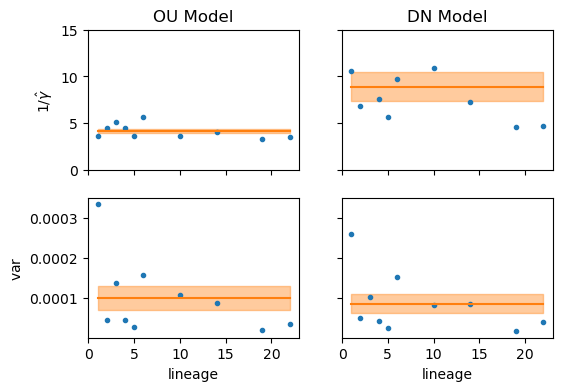

In [23]:
fig,axs = subplots(figsize=(6,4),ncols=2,nrows = 2,sharey="row",sharex=true)

ax = axs[0,0]
ax.plot(lineages, 1.0 ./ d_fits.γ_OU,".")
m, v= mean(1.0 ./ d_fits.γ_OU) .* ones(length(lineages)), std(1.0 ./ d_fits.γ_OU) ./ sqrt(10)
ax.plot(lineages, m,"-")
ax.fill_between(lineages,m .- v,m .+ v,color="C1",alpha=0.4)
ax.set_ylim([0,15])

ax.set_ylabel(L"$1/\hat{\gamma}$")
ax.set_title("OU Model")

ax = axs[0,1]
ax.set_title("DN Model")
ax.plot(lineages , 1.0 ./ d_fits.γ_DN,".")
m, v= mean(1.0 ./ d_fits.γ_DN) .* ones(length(lineages)), std(1.0 ./ d_fits.γ_DN) ./ sqrt(10)
ax.plot(lineages, m,"-")
ax.fill_between(lineages,m .- v,m .+ v,color="C1",alpha=0.4)


ax = axs[1,0]
ax.plot(lineages, d_fits.D ./ d_fits.γ_OU,".")
m, v= mean(d_fits.D ./ d_fits.γ_OU) .* ones(length(lineages)), std(d_fits.D ./ d_fits.γ_OU) ./ sqrt(10)
ax.plot(lineages, m,"-")
ax.fill_between(lineages,m .- v,m .+ v,color="C1",alpha=0.4)

ax.set_ylabel(L"${\rm var}$")
ax.set_xlabel("lineage")

ax = axs[1,1]
ax.plot(lineages , d_fits.v,".")
m, v= mean(d_fits.v) .* ones(length(lineages)), std(d_fits.v) ./ sqrt(10)
ax.plot(lineages, m,"-")
ax.fill_between(lineages,m .- v,m .+ v,color="C1",alpha=0.4)

ax.set_xlabel("lineage")
fig

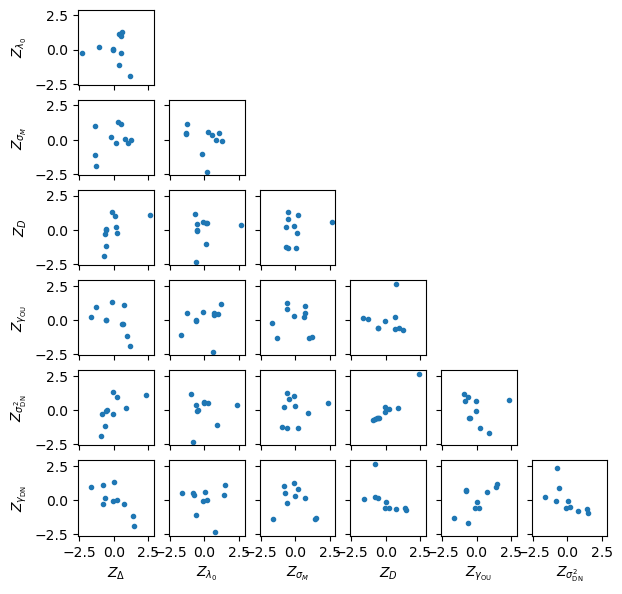

In [25]:
cols =["Δ","λ0","σM","D","γ_OU","v","γ_DN"]
labels =[L"$Z_{\Delta}$",L"$Z_{\lambda_0}$",L"$Z_{\sigma_M}$",L"$Z_{D}$",L"$Z_{\gamma_{\rm OU}}$",L"$Z_{\sigma_{\rm DN}^2}$",L"$Z_{\gamma_{\rm DN}}$"]

zscore = x ->  (x .- mean(x)) ./ std(x)
fig, axs= subplots(figsize=(8,8),ncols = length(cols),nrows=length(cols),sharex=true,sharey=true)
for i in eachindex(cols)
    axs[length(cols)-1,i-1].set_xlabel(labels[i])
    axs[i-1,0].set_ylabel(labels[i])
    for j in eachindex(cols)[1:i-1]
        ax = axs[i-1,j-1]
        ax.plot(zscore(d_fits[:,cols[i]]),zscore(d_fits[:,cols[j]]),".")
    end
    for j in eachindex(cols)[i:length(cols)]
        ax = axs[i-1,j-1]
        ax.spines["top"].set_visible(false)
        ax.spines["right"].set_visible(false)
        ax.spines["bottom"].set_visible(false)
        ax.spines["left"].set_visible(false)
        fig.delaxes(ax)
    end
end

savefig("./../figures/supp_fits-corrs.pdf")
fig